In [1]:
import numpy as np 
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.set_option('display.max_rows', 500)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

## Application_train and Application_test

In [5]:
print('Read data and test')
data = pd.read_csv('E:/DePaul_Dataset/Home_Credit_Evaluation_Dataset/application_train.csv')
test = pd.read_csv('E:/DePaul_Dataset/Home_Credit_Evaluation_Dataset/application_test.csv')
print('Shapes : ', data.shape, test.shape)

y = data['TARGET']
ids = data['SK_ID_CURR']
del data['TARGET']

categorical_feats = [f for f in data.columns if data[f].dtype == 'object']
categorical_feats
for f_ in categorical_feats:
    data[f_], indexer = pd.factorize(data[f_])
    test[f_] = indexer.get_indexer(test[f_])

Read data and test
Shapes :  (307511, 122) (48744, 121)


## Bureau_balance

In [3]:
buro_bal = pd.read_csv('bureau_balance.csv')
print('Buro bal shape : ', buro_bal.shape)

print('transform to dummies with shape:',buro_bal.shape)
buro_bal = pd.concat([buro_bal, pd.get_dummies(buro_bal.STATUS, 
                                               prefix='buro_bal_status')],axis=1).drop('STATUS', axis=1)

print('Counting buros with buro_bal dummies:',buro_bal.shape)
buro_counts = buro_bal[['SK_ID_BUREAU', 'MONTHS_BALANCE']].groupby('SK_ID_BUREAU').count()
buro_bal['buro_count'] = buro_bal['SK_ID_BUREAU'].map(buro_counts['MONTHS_BALANCE'])

print('averaging buro bal')
print('buro_bal shape:', buro_bal.shape, 'and buro_counts shape:', buro_counts.shape)
avg_buro_bal = buro_bal.groupby('SK_ID_BUREAU').mean()

avg_buro_bal.columns = ['avg_buro_' + f_ for f_ in avg_buro_bal.columns]
print('avg_buro_bal',avg_buro_bal.shape)

Buro bal shape :  (27299925, 3)
transform to dummies with shape: (27299925, 3)
Counting buros with buro_bal dummies: (27299925, 10)
averaging buro bal
buro_bal shape: (27299925, 11) and buro_counts shape: (817395, 1)
avg_buro_bal (817395, 10)


In [4]:
buro_bal.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,buro_bal_status_0,buro_bal_status_1,buro_bal_status_2,buro_bal_status_3,buro_bal_status_4,buro_bal_status_5,buro_bal_status_C,buro_bal_status_X,buro_count
0,5715448,0,0,0,0,0,0,0,1,0,27
1,5715448,-1,0,0,0,0,0,0,1,0,27
2,5715448,-2,0,0,0,0,0,0,1,0,27


In [5]:
buro_counts.head(3)

,MONTHS_BALANCE
SK_ID_BUREAU,
5001709,97
5001710,83
5001711,4


In [6]:
avg_buro_bal.head(2)

,avg_buro_MONTHS_BALANCE,avg_buro_buro_bal_status_0,avg_buro_buro_bal_status_1,avg_buro_buro_bal_status_2,avg_buro_buro_bal_status_3,avg_buro_buro_bal_status_4,avg_buro_buro_bal_status_5,avg_buro_buro_bal_status_C,avg_buro_buro_bal_status_X,avg_buro_buro_count
SK_ID_BUREAU,,,,,,,,,,
5001709,-48.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.886598,0.113402,97.0
5001710,-41.0,0.060241,0.0,0.0,0.0,0.0,0.0,0.578313,0.361446,83.0


In [7]:
del buro_bal
gc.collect()

169

## Bureau

In [8]:
print('Read Bureau')
buro = pd.read_csv('bureau.csv')

print('Go to dummies with shape:',buro.shape)
buro_credit_active_dum = pd.get_dummies(buro.CREDIT_ACTIVE, prefix='ca_')
buro_credit_currency_dum = pd.get_dummies(buro.CREDIT_CURRENCY, prefix='cu_')
buro_credit_type_dum = pd.get_dummies(buro.CREDIT_TYPE, prefix='ty_')
print('creating the dummies for CREDIT_ACTIVE, CREDIT_CURRENCY, CREDIT_TYPE using prefix ca_, cu_, ty_')
buro_full = pd.concat([
            buro, buro_credit_active_dum, buro_credit_currency_dum,
            buro_credit_type_dum],axis=1)
print('buro_full dummies Shape: ', buro_full.shape)

Read Bureau
Go to dummies with shape: (1716428, 17)
creating the dummies for CREDIT_ACTIVE, CREDIT_CURRENCY, CREDIT_TYPE using prefix ca_, cu_, ty_
buro_full dummies Shape:  (1716428, 40)


In [9]:
buro_full.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,ty__Interbank credit,ty__Loan for business development,ty__Loan for purchase of shares (margin lending),ty__Loan for the purchase of equipment,ty__Loan for working capital replenishment,ty__Microloan,ty__Mobile operator loan,ty__Mortgage,ty__Real estate loan,ty__Unknown type of loan
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
del buro_credit_active_dum, buro_credit_currency_dum, buro_credit_type_dum
gc.collect()

494

## Merging bureau and bureau_balance

In [11]:
print('Merge with buro avg')
buro_full = buro_full.merge(right=avg_buro_bal.reset_index(),how='left',
                            on='SK_ID_BUREAU',suffixes=('', '_bur_bal'))
print('merging with left join on SK_ID_BUREAU')
print('buro_full shape:', buro_full.shape)
print('Counting buro per SK_ID_CURR')

nb_bureau_per_curr = buro_full[['SK_ID_CURR', 'SK_ID_BUREAU']].groupby('SK_ID_CURR').count()
buro_full['SK_ID_BUREAU'] = buro_full['SK_ID_CURR'].map(nb_bureau_per_curr['SK_ID_BUREAU'])
print('nb_bureau shape:', buro_full.shape)
print('Averaging bureau')

avg_buro = buro_full.groupby('SK_ID_CURR').mean()
print('final avg_buro shape:', avg_buro.shape)

Merge with buro avg
merging with left join on SK_ID_BUREAU
buro_full shape: (1716428, 50)
Counting buro per SK_ID_CURR
nb_bureau shape: (1716428, 50)
Averaging bureau
final avg_buro shape: (305811, 46)


In [12]:
avg_buro.head(3)

,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,avg_buro_MONTHS_BALANCE,avg_buro_buro_bal_status_0,avg_buro_buro_bal_status_1,avg_buro_buro_bal_status_2,avg_buro_buro_bal_status_3,avg_buro_buro_bal_status_4,avg_buro_buro_bal_status_5,avg_buro_buro_bal_status_C,avg_buro_buro_bal_status_X,avg_buro_buro_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7.0,-735.00,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.00000,...,-11.785714,0.336651,0.007519,0.0,0.0,0.0,0.0,0.441240,0.214590,24.571429
100002,8.0,-874.00,0.0,-349.000000,-697.500000,1681.029,0.0,108131.945625,49156.200000,7997.14125,...,-21.875000,0.406960,0.255682,0.0,0.0,0.0,0.0,0.175426,0.161932,13.750000
100003,4.0,-1400.75,0.0,-544.500000,-1097.333333,0.000,0.0,254350.125000,0.000000,202500.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
buro_full.head(2)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,...,avg_buro_MONTHS_BALANCE,avg_buro_buro_bal_status_0,avg_buro_buro_bal_status_1,avg_buro_buro_bal_status_2,avg_buro_buro_bal_status_3,avg_buro_buro_bal_status_4,avg_buro_buro_bal_status_5,avg_buro_buro_bal_status_C,avg_buro_buro_bal_status_X,avg_buro_buro_count
0,215354,11,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,11,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
nb_bureau_per_curr.head(2)

,SK_ID_BUREAU
SK_ID_CURR,
100001,7
100002,8


In [15]:
del buro, buro_full
gc.collect()

614

## previous_application

In [16]:
print('Read prev')
prev = pd.read_csv('previous_application.csv')

prev_cat_features = [f_ for f_ in prev.columns if prev[f_].dtype == 'object']
print("shape:", prev.shape)
print('Go to dummies')
prev_dum = pd.DataFrame()
for f_ in prev_cat_features:
    prev_dum = pd.concat([prev_dum, 
                          pd.get_dummies(prev[f_], prefix=f_).astype(np.uint8)],axis=1)
print('prev_dum shape:',prev_dum.shape)
print('concat prev and prev_dum')
prev = pd.concat([prev, prev_dum], axis=1)
print('final prev shape:', prev.shape)

Read prev
shape: (1670214, 37)
Go to dummies
prev_dum shape: (1670214, 143)
concat prev and prev_dum
final prev shape: (1670214, 180)


In [22]:
prev.head(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,0,0,0,0,0,0,1,0,0,0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,1,0,0,0,0,0,0,0,0,0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print('Counting number of Prevs')
nb_prev_per_curr = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev['SK_ID_PREV'] = prev['SK_ID_CURR'].map(nb_prev_per_curr['SK_ID_PREV'])

print('Averaging prev')
avg_prev = prev.groupby('SK_ID_CURR').mean()
print('final avg_prev shape:', avg_prev.shape)

Counting number of Prevs
Averaging prev
final avg_prev shape: (338857, 163)


In [19]:
avg_prev.head(3)

,SK_ID_PREV,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.0,3951.000,24835.5,23787.0,2520.0,24835.5,13.000000,1.0,0.104326,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
100002,1.0,9251.775,179055.0,179055.0,0.0,179055.0,9.000000,1.0,0.000000,NaN,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
100003,3.0,56553.990,435436.5,484191.0,3442.5,435436.5,14.666667,1.0,0.050030,NaN,...,0.333333,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,0.0


In [20]:
del prev_dum
del prev
gc.collect()

513

## POS_CASH_balance.csv

In [21]:
print('Reading POS_CASH')
pos = pd.read_csv('POS_CASH_balance.csv')
print('pos shape', pos.shape)
print('Go to dummies')
pos = pd.concat([pos, pd.get_dummies(pos['NAME_CONTRACT_STATUS'])], axis=1)
print('pos shape after dummies', pos.shape)
print('Compute nb of prevs per curr')
nb_prevs = pos[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
pos['SK_ID_PREV'] = pos['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
print('final pos shape', pos.shape)

Reading POS_CASH
pos shape (10001358, 8)
Go to dummies
pos shape after dummies (10001358, 17)
Compute nb of prevs per curr
final pos shape (10001358, 17)


In [22]:
pos.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,Active,Amortized debt,Approved,Canceled,Completed,Demand,Returned to the store,Signed,XNA
0,43,182943,-31,48.0,45.0,Active,0,0,1,0,0,0,0,0,0,0,0
1,27,367990,-33,36.0,35.0,Active,0,0,1,0,0,0,0,0,0,0,0
2,109,397406,-32,12.0,9.0,Active,0,0,1,0,0,0,0,0,0,0,0
3,114,269225,-35,48.0,42.0,Active,0,0,1,0,0,0,0,0,0,0,0
4,126,334279,-35,36.0,35.0,Active,0,0,1,0,0,0,0,0,0,0,0


In [23]:
print('Go to averages')
avg_pos = pos.groupby('SK_ID_CURR').mean()
print('averaging final pos shape:',avg_pos.shape)

Go to averages
averaging final pos shape: (337252, 15)


In [24]:
avg_pos.head(3)

,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,Active,Amortized debt,Approved,Canceled,Completed,Demand,Returned to the store,Signed,XNA
SK_ID_CURR,,,,,,,,,,,,,,,
100001,9.0,-72.555556,4.000000,1.444444,0.777778,0.777778,0.777778,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0
100002,19.0,-10.000000,24.000000,15.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
100003,28.0,-43.785714,10.107143,5.785714,0.000000,0.000000,0.928571,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.0


In [25]:
del pos, nb_prevs
gc.collect()

244

## credit_card_balance

In [26]:
print('Reading CC balance')
cc_bal = pd.read_csv('credit_card_balance.csv')
print('cc_bal shape:', cc_bal.shape)
print('Go to dummies')
cc_bal = pd.concat([cc_bal, pd.get_dummies(
    cc_bal['NAME_CONTRACT_STATUS'], prefix='cc_bal_status_')],axis=1)
print('cc_bal shape after dummies:', cc_bal.shape)
nb_prevs = cc_bal[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
cc_bal['SK_ID_PREV'] = cc_bal['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])

print('Compute average')
avg_cc_bal = cc_bal.groupby('SK_ID_CURR').mean()
avg_cc_bal.columns = ['cc_bal_' + f_ for f_ in avg_cc_bal.columns]
print('avg_cc_bal final shape:', avg_cc_bal.shape)

Reading CC balance
cc_bal shape: (3840312, 23)
Go to dummies
cc_bal shape after dummies: (3840312, 30)
Compute average
avg_cc_bal final shape: (103558, 28)


In [27]:
avg_cc_bal.head(3)

,cc_bal_SK_ID_PREV,cc_bal_MONTHS_BALANCE,cc_bal_AMT_BALANCE,cc_bal_AMT_CREDIT_LIMIT_ACTUAL,cc_bal_AMT_DRAWINGS_ATM_CURRENT,cc_bal_AMT_DRAWINGS_CURRENT,cc_bal_AMT_DRAWINGS_OTHER_CURRENT,cc_bal_AMT_DRAWINGS_POS_CURRENT,cc_bal_AMT_INST_MIN_REGULARITY,cc_bal_AMT_PAYMENT_CURRENT,...,cc_bal_CNT_INSTALMENT_MATURE_CUM,cc_bal_SK_DPD,cc_bal_SK_DPD_DEF,cc_bal_cc_bal_status__Active,cc_bal_cc_bal_status__Approved,cc_bal_cc_bal_status__Completed,cc_bal_cc_bal_status__Demand,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,6.0,-3.5,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100011,74.0,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.0,3956.221849,4843.064189,...,25.767123,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
100013,96.0,-48.5,18159.919219,131718.750000,6350.000000,5953.125000,0.0,0.0,1454.539551,7168.346250,...,18.719101,0.010417,0.010417,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
del cc_bal, nb_prevs
gc.collect()

541

## installment_payments

In [29]:
print('Reading Installments')
inst = pd.read_csv('installments_payments.csv')
print('inst shape:', inst.shape)
nb_prevs = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
inst['SK_ID_PREV'] = inst['SK_ID_CURR'].map(nb_prevs['SK_ID_PREV'])
print('inst shape after dummies:', inst.shape)
avg_inst = inst.groupby('SK_ID_CURR').mean()
avg_inst.columns = ['inst_' + f_ for f_ in avg_inst.columns]
print('final avg_inst shape:', avg_inst.shape)

Reading Installments
inst shape: (13605401, 8)
inst shape after dummies: (13605401, 8)
final avg_inst shape: (339587, 7)


## Final step : merging all the values

In [30]:
data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
print('data shape on merging avg_buro:', data.shape, test.shape)
data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
print('data shape on merging avg_prev:', data.shape, test.shape)
data = data.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_pos.reset_index(), how='left', on='SK_ID_CURR')
print('data shape on merging avg_pos:', data.shape, test.shape)
data = data.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_cc_bal.reset_index(), how='left', on='SK_ID_CURR')
print('data shape on merging avg_cc_bal:', data.shape, test.shape)
data = data.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_inst.reset_index(), how='left', on='SK_ID_CURR')
print('data shape on merging avg_inst:', data.shape, test.shape)

data shape on merging avg_buro: (307511, 167) (48744, 167)
data shape on merging avg_prev: (307511, 330) (48744, 330)
data shape on merging avg_pos: (307511, 345) (48744, 345)
data shape on merging avg_cc_bal: (307511, 373) (48744, 373)
data shape on merging avg_inst: (307511, 380) (48744, 380)


In [31]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed,inst_SK_ID_PREV,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,19.0,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,25.0,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,3.0,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,16.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,66.0,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227


In [32]:
y.shape

(307511,)

In [33]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

In [34]:
ids = data['SK_ID_CURR']

In [35]:
test.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed,inst_SK_ID_PREV,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100001,0,1,0,0,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,7.0,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143
1,100005,0,0,0,0,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,9.0,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000


In [36]:
del avg_buro, avg_prev
gc.collect()

554

**LOGISTIC REGRESSION**

In [37]:
# since names of the data file is different, correcting the name to 
# correspond with my original methods
train=data
#test # test data set containing
target=y # target value
print('Train data:', train.shape, 'and Target train data:', target.shape, 'and Test Data:', test.shape)


Train data: (307511, 380) and Target train data: (307511,) and Test Data: (48744, 380)


In [38]:
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed,inst_SK_ID_PREV,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100002,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,19.0,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,25.0,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,64754.586000
2,100004,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,3.0,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,16.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,62947.088438
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,66.0,1.166667,7.045455,-1028.606061,-1032.242424,12666.444545,12214.060227


In [39]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed,inst_SK_ID_PREV,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100001,0,1,0,0,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,7.0,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143
1,100005,0,0,0,0,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,9.0,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000
2,100013,0,0,1,0,0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,155.0,0.277419,43.729032,-1352.929032,-1358.109677,10897.898516,9740.235774
3,100028,0,1,0,0,2,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,113.0,0.460177,30.504425,-855.548673,-858.548673,4979.282257,4356.731549
4,100038,0,0,1,1,1,180000.0,625500.0,32067.0,625500.0,...,NaN,NaN,NaN,12.0,1.000000,6.500000,-622.000000,-634.250000,11100.337500,11100.337500


In [40]:
# Exploratory Data Analysis
# let's count the target value in app_trn dataset
target.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [41]:
# let's plot this outcome in histogram 
target.astype(int).plot.hist();

In [42]:
# Function to calculate missing values by column# Funct  (Will willkoehrsen kernel)
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [43]:
# Missing values statistics
missing_values = missing_values_table(train)
missing_values.head(20)

Your selected dataframe has 380 columns.
There are 320 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,302902,98.5
RATE_INTEREST_PRIVILEGED,302902,98.5
cc_bal_AMT_PAYMENT_CURRENT,246451,80.1
cc_bal_CNT_DRAWINGS_POS_CURRENT,246371,80.1
cc_bal_CNT_DRAWINGS_OTHER_CURRENT,246371,80.1
cc_bal_CNT_DRAWINGS_ATM_CURRENT,246371,80.1
cc_bal_AMT_DRAWINGS_ATM_CURRENT,246371,80.1
cc_bal_AMT_DRAWINGS_OTHER_CURRENT,246371,80.1
cc_bal_AMT_DRAWINGS_POS_CURRENT,246371,80.1
AMT_ANNUITY_y,227502,74.0


Let's find each column types for TRAIN dataset. Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either discrete or continuous). object columns contain strings and are categorical features.

In [44]:
train=pd.DataFrame(train)

#train.columns.values
test.head(2)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed,inst_SK_ID_PREV,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100001,0,1,0,0,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,7.0,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143
1,100005,0,0,0,0,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,9.0,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000


Fill all missing values using imputer function and scale all cells using MinMaxScaler function

In [45]:
from sklearn.preprocessing import MinMaxScaler, Imputer

test.head()
print(train.shape)

#let's copy all the feature of the train and test features
train_features=list(train.columns)
test_features=list(test.columns)

# copy the SK_ID_CURR' from train and test
train_SK_ID_CURR=train['SK_ID_CURR']
test_SK_ID_CURR=test['SK_ID_CURR']

# let's drop the column 'SK_ID_CURR' from train and test as it will not 
# provide any use ful insite as these id's are random
#train1=train.drop(columns=['SK_ID_CURR'])
#test1=test.drop(columns=['SK_ID_CURR'])

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data with median imputed values for missing data
#imputer.fit(train1)
imputer.fit(train)

# Transform both training and testing data
##trainTrn = imputer.transform(train1)
trainTrn = imputer.transform(train)
testTrn = imputer.transform(test)

# Repeat with the scaler
scaler.fit(trainTrn)
trainSC = scaler.transform(trainTrn)
testSC = scaler.transform(testTrn)

print('Training data shape: ', trainSC.shape)
print('Testing data shape: ', testSC.shape)

trainSC=pd.DataFrame(trainSC, columns=train_features)
trainSC.isnull().sum().sum()
testSC=pd.DataFrame(testSC, columns=test_features)
testSC.isnull().sum().sum()

(307511, 380)
Training data shape:  (307511, 380)
Testing data shape:  (48744, 380)


0

In [46]:
print(trainSC.head())
print(testSC.head())

   SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0    0.000000                 0.0          0.0           0.0              0.0   
1    0.000003                 0.0          0.5           0.0              1.0   
2    0.000006                 1.0          0.0           1.0              0.0   
3    0.000011                 0.0          0.5           0.0              0.0   
4    0.000014                 0.0          0.0           0.0              0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  AMT_ANNUITY_x  \
0           0.0          0.001512      0.090287       0.090032   
1           0.0          0.002089      0.311736       0.132924   
2           0.0          0.000358      0.022472       0.020025   
3           0.0          0.000935      0.066837       0.109477   
4           0.0          0.000819      0.116854       0.078975   

   AMT_GOODS_PRICE_x        ...         cc_bal_cc_bal_status__Refused  \
0           0.077441        ...            

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

print('Finding hyperparameter for LR')
clf = LogisticRegression()
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
gridsearch = GridSearchCV(clf, param_grid)
gridsearch.fit(trainSC,target);
print ("Best Parameters... ", gridsearch.best_params_)

Finding hyperparameter for LR
Best Parameters...  {'C': 0.1, 'penalty': 'l1'}


In [48]:
gridsearch.best_params_['penalty']

'l1'

In [83]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=None)
pred_test_full =0
cv_score =[]
scores_trn=[]
i=1
for train_index,test_index in kf.split(trainSC, target):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = trainSC.loc[train_index],trainSC.loc[test_index]
    ytr,yvl = target.loc[train_index],target.loc[test_index]
    
    lr_kf = LogisticRegression(C=0.1, penalty='l1') # hard coded the best parameters
    lr_kf.fit(xtr,ytr)
    score = roc_auc_score(yvl,lr_kf.predict(xvl))
    print('ROC AUC score (test):',score)
    cv_score.append(score)    
    #pred_test = lr.predict_proba(x_test)[:,1]
    #pred_test_full +=pred_test
    i+=1
    
    score = roc_auc_score(ytr,lr_kf.predict(xtr))
    scores_trn.append(score)
    print('ROC AUC score (train):',scores_trn)

1 of KFold 5
ROC AUC score (test): 0.5088295239551742
ROC AUC score (train): [0.5079213140300907]
2 of KFold 5
ROC AUC score (test): 0.5073734280294944
ROC AUC score (train): [0.5079213140300907, 0.508617906965302]
3 of KFold 5
ROC AUC score (test): 0.5091881136008375
ROC AUC score (train): [0.5079213140300907, 0.508617906965302, 0.5081103174511888]
4 of KFold 5
ROC AUC score (test): 0.5075945221802275
ROC AUC score (train): [0.5079213140300907, 0.508617906965302, 0.5081103174511888, 0.5085781101941466]
5 of KFold 5
ROC AUC score (test): 0.5085519324376887
ROC AUC score (train): [0.5079213140300907, 0.508617906965302, 0.5081103174511888, 0.5085781101941466, 0.5088462050372132]


In [50]:
target.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [51]:
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Cv [0.5080980585845586, 0.5081491126995216, 0.510018287625669, 0.5078612619197357, 0.5083878943823134] 
Mean cv Score 0.5085029230423597


In [52]:
test.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,cc_bal_cc_bal_status__Refused,cc_bal_cc_bal_status__Sent proposal,cc_bal_cc_bal_status__Signed,inst_SK_ID_PREV,inst_NUM_INSTALMENT_VERSION,inst_NUM_INSTALMENT_NUMBER,inst_DAYS_INSTALMENT,inst_DAYS_ENTRY_PAYMENT,inst_AMT_INSTALMENT,inst_AMT_PAYMENT
0,100001,0,1,0,0,0,135000.0,568800.0,20560.5,450000.0,...,NaN,NaN,NaN,7.0,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143
1,100005,0,0,0,0,0,99000.0,222768.0,17370.0,180000.0,...,NaN,NaN,NaN,9.0,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000


**Stratified Logistic Regression Reciever Operating Characteristics Curve **

In [53]:
proba = lr.predict_proba(xvl)[:,1]
frp,trp, threshold = roc_curve(yvl,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('Logistic Regression Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

**Logistic Regression AUC Score on Test data **

In [54]:
lr_prd_cmpt_dt_kf = lr.predict_proba(testSC)[:,1]
# Submission dataframe
submit = test[['SK_ID_CURR']]
submit['TARGET'] = lr_prd_cmpt_dt_kf

submit.head()

# Save the submission to a csv file
submit.to_csv('log_reg_complete_data_kf.csv', index = False)

**AdaBoost**

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

ab_clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(ab_clf, trainSC, target, cv=5)
scores.mean()

0.9192093939311548

**AdaBoost using stratifiedKfold value**

In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

# classing with different estimators and learning rates to find the best parameter
ab_clf50 = AdaBoostClassifier(n_estimators=50, learning_rate=0.1)
ab_clf50.fit(trainSC,target);
ab_clf51 = AdaBoostClassifier(n_estimators=50, learning_rate=1)
ab_clf51.fit(trainSC,target);
ab_clf100 = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
ab_clf100.fit(trainSC,target);
ab_clf101 = AdaBoostClassifier(n_estimators=100, learning_rate=1)
ab_clf101.fit(trainSC,target);

In [102]:
from sklearn.model_selection import cross_validate

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=None)
pred_test_full =0
cv_score_abc =[]
scores_trn=[]
i=1
for train_index,test_index in kf.split(trainSC, target):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = trainSC.loc[train_index],trainSC.loc[test_index]
    ytr,yvl = target.loc[train_index],target.loc[test_index]
    
    #model with best parameters from not staratified part
    abc = AdaBoostClassifier(base_estimator=None, n_estimators=100,
                                  algorithm='SAMME.R',random_state=42,learning_rate=1)
    abc.fit(xtr,ytr)
    score = roc_auc_score(yvl, abc.predict(xvl))
    print('ROC AUC score (test):',score)
    cv_score_abc.append(score)    
    #pred_test = lr.predict_proba(x_test)[:,1]
    #pred_test_full +=pred_test
    i+=1
    
    score = roc_auc_score(ytr,abc.predict(xtr))
    scores_trn.append(score)
    print('ROC AUC score (train):',scores_trn)

1 of KFold 5
ROC AUC score (test): 0.5163846971248063
ROC AUC score (train): [0.5193913361302434]
2 of KFold 5
ROC AUC score (test): 0.5183368586383761
ROC AUC score (train): [0.5193913361302434, 0.5185236559475486]
3 of KFold 5
ROC AUC score (test): 0.5198052105759472
ROC AUC score (train): [0.5193913361302434, 0.5185236559475486, 0.5184332916275461]
4 of KFold 5
ROC AUC score (test): 0.5187077268206451
ROC AUC score (train): [0.5193913361302434, 0.5185236559475486, 0.5184332916275461, 0.5200078407253865]
5 of KFold 5
ROC AUC score (test): 0.5169058785145131
ROC AUC score (train): [0.5193913361302434, 0.5185236559475486, 0.5184332916275461, 0.5200078407253865, 0.5177672978723128]


AdaBoost AUC score without stratifiedKfold data for differnt parameters (n_estimators =50, 100 and learning rate=0.1 and 1

In [97]:
abc_prd_cmpt_dt50 = ab_clf50.predict_proba(testSC)[:,1]
# Submission dataframe for the n_estimator = 50 and learning rate = 0.1
submit = test[['SK_ID_CURR']]
submit['TARGET'] = abc_prd_cmpt_dt50
submit.head()
# Save the submission to a csv file
submit.to_csv('abc_prd_cmpt_dt50.csv', index = False)

# Submission dataframe for the n_estimator = 50 and learning rate = 1
abc_prd_cmpt_dt51 = ab_clf51.predict_proba(testSC)[:,1]
# Submission dataframe
submit = test[['SK_ID_CURR']]
submit['TARGET'] = abc_prd_cmpt_dt51
submit.head()
# Save the submission to a csv file
submit.to_csv('abc_prd_cmpt_dt51.csv', index = False)

# Submission dataframe for the n_estimator = 100 and learning rate = 0.1
abc_prd_cmpt_dt100 = ab_clf100.predict_proba(testSC)[:,1]
# Submission dataframe
submit = test[['SK_ID_CURR']]
submit['TARGET'] = abc_prd_cmpt_dt100
submit.head()
# Save the submission to a csv file
submit.to_csv('abc_prd_cmpt_dt100.csv', index = False)

# Submission dataframe for the n_estimator = 100 and learning rate = 1
abc_prd_cmpt_dt101 = ab_clf101.predict_proba(testSC)[:,1]
# Submission dataframe
submit = test[['SK_ID_CURR']]
submit['TARGET'] = abc_prd_cmpt_dt101
submit.head()
# Save the submission to a csv file
submit.to_csv('abc_prd_cmpt_dt101.csv', index = False)

AdaBoost Reciever Operating Characteristics Curve without statified data **



In [115]:
# For n equal to 50 and learning rate equal to 0.1
proba = ab_clf50.predict_proba(trainSC)[:,1]
frp,trp, threshold = roc_curve(target,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('AdaBoost Reciever Operating Characteristics without Stratified Samples for n=50 and learning rate = 0.1')
plt.legend(loc='lower right')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [99]:
# For n equal to 50 and learning rate equal to 1
proba = ab_clf51.predict_proba(trainSC)[:,1]
frp,trp, threshold = roc_curve(target,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('AdaBoost Reciever Operating Characteristics without Stratified Samples for n=50 and learning rate = 1')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')


In [100]:
# For n equal to 100 and learning rate equal to 0.1
proba = ab_clf100.predict_proba(trainSC)[:,1]
frp,trp, threshold = roc_curve(target,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('AdaBoost Reciever Operating Characteristics without Stratified Samples for n=100 and learning rate = 0.1')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [101]:
# For n equal to 100 and learning rate equal to 1
proba = ab_clf101.predict_proba(trainSC)[:,1]
frp,trp, threshold = roc_curve(target,proba)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('AdaBoost Reciever Operating Characteristics without Stratified Samples for n=100 and learning rate = 1')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

**Stratified AdaBoost Algorithm Reciever Operating Characteristics Curve**

In [57]:
proba_abc = abc.predict_proba(xvl)[:,1]
frp,trp, threshold = roc_curve(yvl,proba_abc)
roc_auc_ = auc(frp,trp)

plt.figure(figsize=(14,8))
plt.title('AdaBoost Reciever Operating Characteristics')
plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'b--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

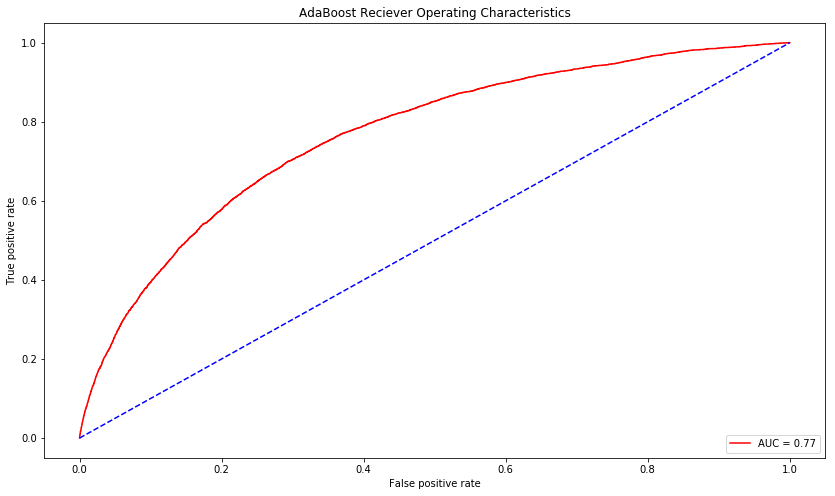

**AdaBoost AUC Score on Test data **

In [58]:
abc_prd_cmpt_dt_kf = abc.predict_proba(testSC)[:,1]
# Submission dataframe
submit = test[['SK_ID_CURR']]
submit['TARGET'] = abc_prd_cmpt_dt_kf

submit.head()

# Save the submission to a csv file
submit.to_csv('abc_prd_cmpt_dt_kf.csv', index = False)

In [59]:
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.489758
1,100005,0.489799
2,100013,0.476407
3,100028,0.481087
4,100038,0.493009


## Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
clf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=50,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

In [60]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Random Forest ROC Curve')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(trainSC.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

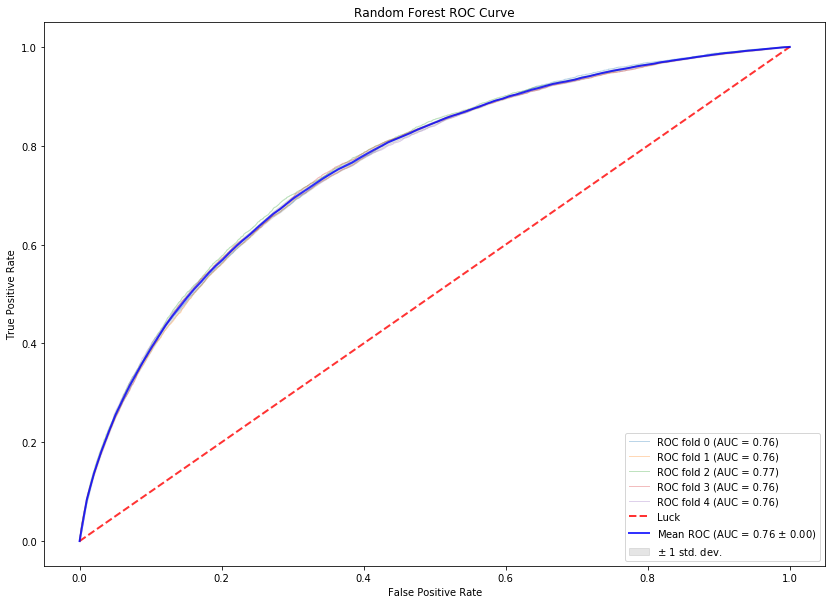

,AUC Train,AUC Test
0,0.765799,0.761380
1,0.766462,0.759680
2,0.764960,0.766086
3,0.766088,0.761788
4,0.766114,0.761271


In [62]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(trainSC, y), range(5)):
    clf.fit(trainSC.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [65]:
randon_forest_pred = clf.predict_proba(testSC)[:, 1]

In [89]:
roc_rf = np.asarray(scores)

In [91]:
roc_rf = roc_rf[:,1] # these are the average auc score for 5-folds on RF.